In [1]:
import sys
from pathlib import Path

# Get the project root path and add it to sys.path
project_root = Path().resolve().parent  # Adjust to point to your project root if necessary
src_path = project_root / 'src'

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

In [2]:
import pandas as pd
import numpy as np
from data_loader import DataLoader
import eda
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
train_id = DataLoader("../data/train_identity.csv")
train_trans = DataLoader("../data/train_transaction.csv")

test_id = DataLoader("../data/test_identity.csv")
test_trans = DataLoader("../data/test_transaction.csv")

print(train_id.dataset.shape)
print(train_trans.dataset.shape)

print(test_id.dataset.shape)
print(test_trans.dataset.shape)

(144233, 41)
(590540, 394)
(141907, 41)
(506691, 393)


In [27]:
train_trans.dataset['TransactionDay'] = train_trans.dataset['TransactionDT']/(60*60*24)

train_trans.dataset['UID_temp'] = train_trans.dataset['D1'].astype(str) + '-' + train_trans.dataset['card1'].astype(str) + '-' + train_trans.dataset['addr1'].astype(str)
uid_map = train_trans.dataset.groupby('UID_temp')['TransactionID'].first().reset_index().rename(columns={'TransactionID': 'UID'})
uid_map['UID'] = uid_map['UID'].astype(np.int32)
train_trans_uid = train_trans.dataset.merge(uid_map, on='UID_temp', how='left', suffixes=('', '_y'))


In [31]:
train_trans_uid[['UID', 'TransactionID', 'TransactionDay', 'TransactionAmt']+ [f'D{i+1}' for i in range(15)] + [f'card{i+1}' for i in range(6)] + ['addr1', 'addr2']].sort_values(by=['UID','TransactionID']).head(10)

,UID,TransactionID,TransactionDay,TransactionAmt,D1,D2,D3,D4,D5,D6,...,D14,D15,card1,card2,card3,card4,card5,card6,addr1,addr2
0,2987000,2987000,1.000000,68.50,14.0,NaN,13.0,NaN,NaN,NaN,...,NaN,0.0,13926,NaN,150.0,discover,142.0,credit,315.0,87.0
1,2987001,2987001,1.000012,29.00,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,0.0,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0
20366,2987001,3007366,6.040856,524.95,0.0,NaN,NaN,14.0,0.0,NaN,...,NaN,0.0,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0
20665,2987001,3007665,6.103623,300.00,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0
20669,2987001,3007669,6.104144,300.00,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0
20844,2987001,3007844,6.143171,300.00,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0
23365,2987001,3010365,6.921644,1183.47,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,0.0,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0
53726,2987001,3040726,14.685243,39.00,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0
63566,2987001,3050566,16.749398,265.00,0.0,NaN,NaN,138.0,22.0,NaN,...,NaN,138.0,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0
66313,2987001,3053313,17.210150,353.95,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,0.0,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0


## Missing Imputation

In [4]:
# separates categorical & numerical variables
num_cols_id = train_id.dataset.select_dtypes(include=['number']).columns
num_cols_trans = train_trans.dataset.select_dtypes(include=['number']).columns
print(f"{len(num_cols_id)}")
print(f"{len(num_cols_trans)}")

# Fill up <UNKWN> token for categorical variables & a integer for numerical (-1) variables

24
380


In [5]:
# Separate categorical & numerical columns
def get_sequential_features(starting_letter, num_start, num_end):
    return [f"{starting_letter}{i}" for i in range(num_start, num_end+1)]

trans_categorical_cols = ['ProductCD'] + get_sequential_features('card', 1, 6) + get_sequential_features('addr', 1, 2) + \
                            ['P_emaildomain', 'R_emaildomain'] + get_sequential_features('M', 1, 9)
id_categorical_cols = ['DeviceType', 'DeviceInfo'] + get_sequential_features('id_', 12, 38)
print(f"Total # of categorical variables in transaction data: {len(trans_categorical_cols)}")
print(f"Total # of categorical variables in id data: {len(id_categorical_cols)}")

trans_num_cols = [c for c in train_trans.dataset.columns.tolist() if c not in trans_categorical_cols]
id_num_cols = [c for c in train_id.dataset.columns.tolist() if c not in id_categorical_cols]
print(f"Total # of numerical variables in transaction data: {len(trans_num_cols)}")
print(f"Total # of numerical variables in id data: {len(id_num_cols)}")

# checks
print(f"Total # of columns in transaction data: {len(trans_categorical_cols) + len(trans_num_cols)}")
print(f"Total # of columns in id data: {len(id_categorical_cols) + len(id_num_cols)}")

Total # of categorical variables in transaction data: 20
Total # of categorical variables in id data: 29
Total # of numerical variables in transaction data: 374
Total # of numerical variables in id data: 12
Total # of columns in transaction data: 394
Total # of columns in id data: 41


In [6]:
# imputing -999 for all the missing values in numerical column
for c in id_num_cols:
    train_id.dataset[c].fillna(-999, inplace=True)

for c in trans_num_cols:
    train_trans.dataset[c].fillna(-999, inplace=True)

In [7]:
# imputing <UNKWN> for all the missing values in categorical column
for c in id_categorical_cols:
    train_id.dataset[c].fillna('<UNKWN>', inplace=True)

for c in trans_categorical_cols:
    train_trans.dataset[c].fillna('<UNKWN>', inplace=True)

## Feature selection/removal

In [8]:
# Remove features with > 90% missing values
features_to_rem_id = ['id_07', 'id_08'] + [f'id_{i}' for i in range(21,28)]
features_to_rem_trans = ['dist1', 'D11'] + [f'M{i}' for i in range(1,10)] + [f'V{i}' for i in range(1,12)]

train_id_v2 = train_id.dataset.drop(features_to_rem_id, axis=1)
train_trans_v2 = train_trans.dataset.drop(features_to_rem_trans, axis=1)

print(train_id_v2.shape)
print(train_trans_v2.shape)

(144233, 32)
(590540, 372)


In [31]:
# Categorical Features:
# ProductCD
# card1 - card6
# addr1, addr2
# P_emaildomain
# R_emaildomain
# M1 - M9

# Categorical Features:
# DeviceType
# DeviceInfo
# id_12 - id_38

In [11]:
train = train_id_v2.merge(train_trans_v2, how='inner', on='TransactionID')
print(train.shape)

(144233, 403)


In [9]:
print(train_id_v2.columns.tolist())
print(train_trans_v2.columns.tolist())

['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D12', 'D13', 'D14', 'D15', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', '

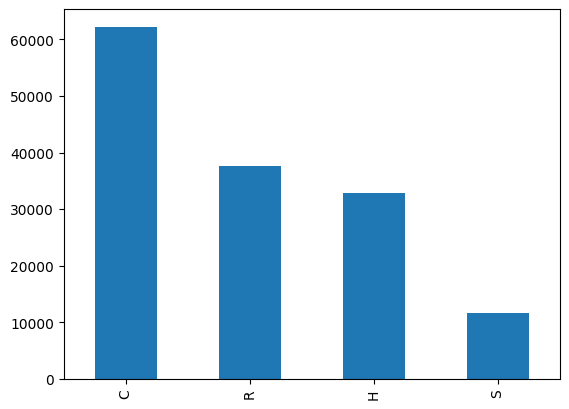

In [12]:
train['ProductCD'].value_counts().plot(kind='bar')
plt.show()

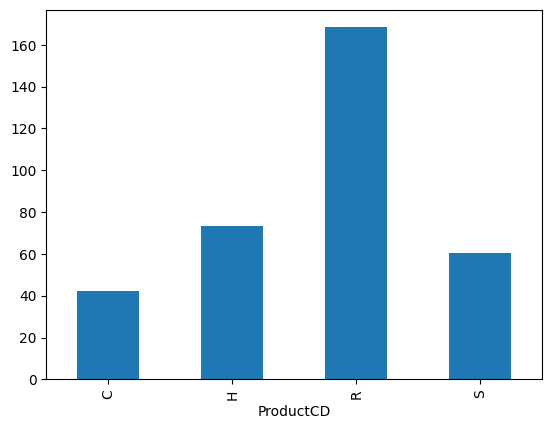

In [13]:
train.groupby(['ProductCD'])['TransactionAmt'].mean().plot(kind='bar')
plt.show()

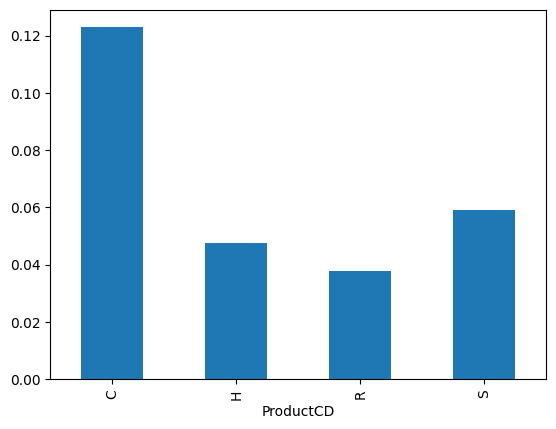

In [ ]:
train.groupby(['ProductCD'])['isFraud'].mean().sort_values(ascending=False).plot(kind='bar')
plt.show()

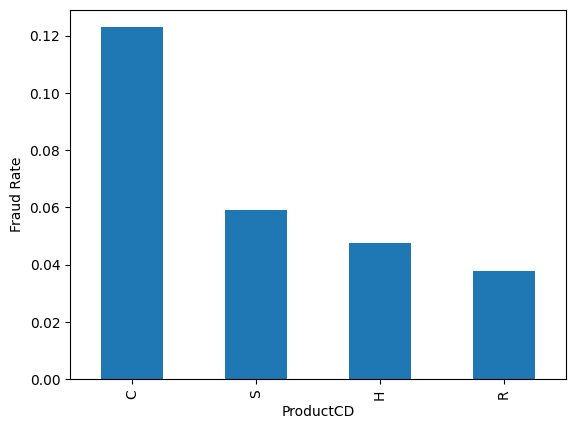

In [28]:
train.groupby(['ProductCD'])['isFraud'].mean().sort_values(ascending=False).plot(kind='bar')
plt.xlabel('ProductCD')
plt.ylabel('Fraud Rate')
plt.show()

/var/folders/fg/rbnh6s990114df6hzsrg0mhc0000gn/T/ipykernel_92295/1170677352.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(diffs, ax=ax)


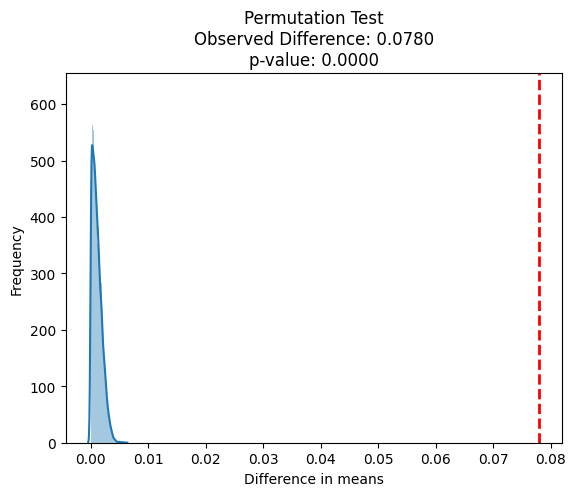

observed difference: 0.07801413912757865
p-value: 0.0


In [ ]:
def permutation_test(control, treatment, n_permutations=10000):
    n_control = len(control)
    n_treatment = len(treatment)
    n = n_control + n_treatment
    observed_diff = np.abs(control.mean() - treatment.mean())
    combined = pd.concat([control, treatment])
    diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(combined.values)
        diff = np.abs(combined[:n_control].mean() - combined[n_control:].mean())
        diffs.append(diff)
    p_value = (np.array(diffs) >= observed_diff).mean()
    return observed_diff, p_value

# Permutation test for ProductCD C
control = train[train['ProductCD'] != 'C']['isFraud']
treatment = train[train['ProductCD'] == 'C']['isFraud']
observed_diff, p_value = permutation_test(control, treatment)
print(f"observed difference: {observed_diff}")
print(f"p-value: {p_value}")

In [ ]:
print(train['ProductCD'].nunique())

Permutation test p-value for ProductCD C: 0.0


In [29]:
control

0         0
1         0
4         0
5         0
6         0
         ..
144217    0
144223    0
144226    0
144229    1
144231    0
Name: isFraud, Length: 82041, dtype: int64